In [100]:
import pandas as pd
import numpy as np
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV
# import xgboost as xgb
from sklearn.metrics import precision_recall_curve
import altair as alt
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import shap
import altair as alt
import pickle
from joblib import dump, load
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

In [103]:
plasma = cm.get_cmap('plasma')

# Prepare the Data

In [3]:
medianIncome = pd.read_csv('median income per state.csv',sep=',', thousands=',')

In [4]:
perCGDP1016 = pd.read_csv('per capita gdp 1016.csv')

In [5]:
gdpPcapita = pd.melt(perCGDP1016, id_vars='Year')

In [6]:
mi = pd.melt(medianIncome, id_vars='State')
mi.head()

State variable  value
0     Alabama     2020  54393
1      Alaska     2020  74476
2     Arizona     2020  66628
3    Arkansas     2020  50540
4  California     2020  77358

In [7]:
gdp18 = pd.read_csv('per capita gdp 18.csv',thousands=',')

In [8]:
gdp20 = pd.read_csv('gdp per capita 20.csv')

In [9]:
gdp20['state'] = gdp20['State Pre'].apply(lambda x: x.rstrip(' *'))

In [10]:
gdp20 = gdp20[['state','GDP per Capita', 'Year']]

In [11]:
gdpPcapita = gdpPcapita.rename(columns={"variable": "state", "value": "GDP per Capita"})
gdp18 = gdp18.rename(columns={"year": "Year"})

In [12]:
gdpPerCapita = gdpPcapita.append(gdp18)
gdpPerCapita = gdpPerCapita.append(gdp20)

In [13]:
mi = mi.rename(columns={"value": "Median Income",'variable': 'Year'})
gdpPerCapita = gdpPerCapita.rename(columns={"state": "State"})

# ev = pd.merge(mi,gdpPerCapita, left_on='State', right_on='Year')

In [14]:
mi['Year'] = mi['Year'].astype(int)

In [15]:
gdpPerCapita['Year'] = gdpPerCapita['Year'].astype(int)

In [16]:
ev = mi.merge(gdpPerCapita,on=['State','Year'])

In [17]:
ef10 = pd.read_csv('elections data/2010_election_data.csv')
ef12 = pd.read_csv('elections data/2012_election_data.csv')
ef14 = pd.read_csv('elections data/2014_election_data.csv')
ef16 = pd.read_csv('elections data/2016_election_data.csv')
ef18 = pd.read_csv('elections data/2018_election_data.csv')
ef20 = pd.read_csv('elections data/2020_election_data.csv')
elections = [ef10,ef12,ef14,ef16,ef18,ef20]

start = elections.pop(0)
# newLabels = []
years = [2010,2012,2014,2016,2018,2020]
for i in elections:
    j = i.drop("Unnamed: 0",axis=1)
    start = start.append(j)
Y = start.copy()

Y = Y.fillna(0)
Y['maskActual'] = Y['rep_votes_share'].apply(lambda x: round(x))

In [18]:
Y = Y.rename(columns={"state": "State",'year':'Year'})
Y

Unnamed: 0          State   DEMOCRAT  INDEPENDENT  REPUBLICAN      Total  \
0          0.0        Alabama   418957.0          0.0    914445.0  1333402.0   
1          1.0         Alaska    77606.0          0.0    175384.0   252990.0   
2          2.0        Arizona   711837.0       4506.0    900510.0  1616853.0   
3          3.0       Arkansas   317975.0       4421.0    435422.0   757818.0   
4          4.0     California  5148828.0      23628.0   4195494.0  9367950.0   
..         ...            ...        ...          ...         ...        ...   
46         0.0       Virginia  2253974.0       9170.0   2047635.0  4310779.0   
47         0.0     Washington  2340356.0          0.0   1545436.0  3885792.0   
48         0.0  West Virginia   246903.0          0.0    514268.0   761171.0   
49         0.0      Wisconsin  1566671.0       7911.0   1661399.0  3235981.0   
50         0.0        Wyoming    66576.0          0.0    185732.0   252308.0   

    dem_votes_share  rep_votes_share  indep_votes_share  Year  maskActual  
0          0.314202         0.685798           0.000000  2010           1  
1          0.306755         0.693245           0.000000  2010           1  
2          0.440261         0.556952           0.002787  2010           1  
3          0.419593         0.574573           0.005834  2010           1  
4          0.549622         0.447856           0.002522  2010           0  
..              ...              ...                ...   ...         ...  
46         0.522869         0.475003           0.002127  2020           0  
47         0.602285         0.397715           0.000000  2020           0  
48         0.324373         0.675627           0.000000  2020           1  
49         0.484141         0.513414           0.002445  2020           1  
50         0.263868         0.736132           0.000000  2020           1  

[301 rows x 11 columns]

In [19]:
y = Y[['State','Year','rep_votes_share','maskActual']]
fv = pd.merge(ev,y,on=['State','Year'])

In [20]:
fv

State  Year  Median Income  GDP per Capita  rep_votes_share  \
0          Alabama  2020          54393         45155.0         0.699327   
1           Alaska  2020          74476         68019.0         0.545840   
2          Arizona  2020          66628         52065.0         0.501407   
3         Arkansas  2020          50540         43407.0         0.714792   
4       California  2020          77358         76132.0         0.337262   
..             ...   ...            ...             ...              ...   
296       Virginia  2010          71822        420862.0         0.554455   
297     Washington  2010          66821        359694.0         0.457837   
298  West Virginia  2010          50894         67255.0         0.554045   
299      Wisconsin  2010          59906        252875.0         0.551118   
300        Wyoming  2010          62107         39103.0         0.742049   

     maskActual  
0             1  
1             1  
2             1  
3             1  
4             0  
..          ...  
296           1  
297           0  
298           1  
299           1  
300           1  

[301 rows x 6 columns]

In [66]:
Xtrain = fv[fv['Year']<2020]
Xtrain = Xtrain[['Median Income','GDP per Capita']]
Xtest = fv[fv['Year']==2020]
Xtest = Xtest[['Median Income','GDP per Capita']]

YtrainR = fv[fv['Year']<2020]
YtrainR = YtrainR['rep_votes_share']
YtrainC = fv[fv['Year']<2020]
YtrainC = YtrainC['maskActual']

YtestR = fv[fv['Year']==2020]
YtestR = YtestR['rep_votes_share']
YtestC = fv[fv['Year']==2020]
YtestC = YtestC['maskActual']

# Run just Economic Variables

In [21]:
params = { 'max_depth': [3,5,7,10],
   'learning_rate': [0.01, 0.05, 0.1],
   'n_estimators': [100,250, 500, 1000],
   'colsample_bytree': [0.3,0.5, 0.7],
  'alpha':[0.0,0.01,0.1,0.5,1.0],
  'lambda':[0.0,0.01,0.1,0.5,1.0],
  'tree_method':['hist'],
#           'eval_metric': ['error','logloss'],
  'objective': ['reg:squarederror','reg:squaredlogerror','reg:logistic']
 }


xgbr = xgb.XGBRegressor(seed=42)

xgbRegress = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_absolute_error', 
                   verbose=2,
                      n_jobs = -1)
xgbRegress.fit(Xtrain,YtrainR)
xgbBest = xgbRegress.best_estimator_

Fitting 5 folds for each of 10800 candidates, totalling 54000 fits


In [68]:
params = { 'max_depth': [3,5,7,10],
   'learning_rate': [0.01, 0.05, 0.1],
   'n_estimators': [100,250, 500, 1000],
   'colsample_bytree': [0.3,0.5, 0.7],
  'alpha':[0.0,0.01,0.1,0.5,1.0],
  'lambda':[0.0,0.01,0.1,0.5,1.0],
  'tree_method':['exact'],
#           'eval_metric': ['error','logloss'],
  'objective': ['reg:squarederror','reg:squaredlogerror','reg:logistic','reg:pseudohubererror','reg:gamma','reg:tweedie']
 }


xgbr = xgb.XGBRegressor(seed=42)

xgbRegressE = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_absolute_error', 
                   verbose=2,
                      n_jobs = -1)
# xgbRegressE.fit(Xtrain,YtrainR)
# xgbBestE = xgbRegress.best_estimator_

In [73]:
xgbRegressB = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_absolute_error', 
                   verbose=2,
                      n_jobs = -1)
xgbRegressE.fit(Xtrain,YtrainR)
xgbBestE = xgbRegressE.best_estimator_
xgbRegressB.fit(XtrainB,YtrainR)
xgbBestB = xgbRegressB.best_estimator_

Fitting 5 folds for each of 21600 candidates, totalling 108000 fits


One or more of the test scores are non-finite: [-0.09270896 -0.09418865 -0.09273632 ... -0.0900489          nan
 -0.09034125]


Fitting 5 folds for each of 21600 candidates, totalling 108000 fits


One or more of the test scores are non-finite: [-0.06652764 -0.06661233 -0.06650575 ... -0.06018839         nan
 -0.05560959]


In [83]:
# Use the forest's predict method on the test data
XGBpredictions = xgbBestB.predict(XtrainB)
# Calculate the absolute errors
errors = abs(XGBpredictions - YtrainR)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', np.mean(errors), 'degrees.')
# Mean Absolute Error: 3.83 degrees.

Mean Absolute Error: 0.002257748045487713 degrees.


In [84]:
# Use the forest's predict method on the test data
XGBpredictions = xgbBestB.predict(XtestB)
# Calculate the absolute errors
errors = abs(XGBpredictions - YtestR)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', np.mean(errors), 'degrees.')
# Mean Absolute Error: 3.83 degrees.

Mean Absolute Error: 0.06114015120106581 degrees.


In [86]:
# Use the forest's predict method on the test data
XGBpredictions = xgbBestB.predict(XtrainB)
# Calculate the absolute errors
errors = (XGBpredictions - YtrainR)**2
# Print out the mean absolute error (mae)
print('Mean Squared Error:', np.mean(errors), 'degrees.')
# Mean Absolute Error: 3.83 degrees.

Mean Squared Error: 1.651946665028284e-05 degrees.


In [87]:
# Use the forest's predict method on the test data
XGBpredictions = xgbBestB.predict(XtestB)
# Calculate the absolute errors
errors = (XGBpredictions - YtestR)**2
# Print out the mean absolute error (mae)
print('Mean Squared Error:', np.mean(errors), 'degrees.')
# Mean Absolute Error: 3.83 degrees.

Mean Squared Error: 0.007881735403743383 degrees.


In [22]:
xgbRegress.best_params_

{'alpha': 0.5,
 'colsample_bytree': 0.3,
 'lambda': 0.01,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 1000,
 'objective': 'reg:squarederror',
 'tree_method': 'hist'}

In [23]:
# Use the forest's predict method on the test data
XGBpredictions = xgbBest.predict(Xtrain)
# Calculate the absolute errors
errors = abs(XGBpredictions - YtrainR)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', np.mean(errors), 'degrees.')
# Mean Absolute Error: 3.83 degrees.

Mean Absolute Error: 0.06784366338466119 degrees.


In [26]:
# Use the forest's predict method on the test data
XGBpredictions = xgbBest.predict(Xtest)
# Calculate the absolute errors
errors = abs(XGBpredictions - YtestR)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', np.mean(errors), 'degrees.')
# Mean Absolute Error: 3.83 degrees.

Mean Absolute Error: 0.08937431724820548 degrees.


In [27]:
# Use the forest's predict method on the test data
XGBpredictions = xgbBest.predict(Xtrain)
# Calculate the absolute errors
errors = (XGBpredictions - YtrainR)**2
# Print out the mean absolute error (mae)
print('Mean Squared Error:', np.mean(errors), 'degrees.')
# Mean Absolute Error: 3.83 degrees.

Mean Squared Error: 0.008112919964601126 degrees.


In [28]:
# Use the forest's predict method on the test data
XGBpredictions = xgbBest.predict(Xtest)
# Calculate the absolute errors
errors = (XGBpredictions - YtestR)**2
# Print out the mean absolute error (mae)
print('Mean Squared Error:', np.mean(errors), 'degrees.')
# Mean Absolute Error: 3.83 degrees.

Mean Squared Error: 0.016234148172020138 degrees.


In [93]:
xNew = XtestB.append(XtrainB)
XGBpredictions = xgbBestB.predict(xNew)
fv['predR'] = XGBpredictions
fv['predRMask'] = fv['predR'].apply(lambda x: round(x))

In [94]:
fv

State  Year  Median Income  GDP per Capita  rep_votes_share  \
0          Alabama  2020          54393         45155.0         0.699327   
1           Alaska  2020          74476         68019.0         0.545840   
2          Arizona  2020          66628         52065.0         0.501407   
3         Arkansas  2020          50540         43407.0         0.714792   
4       California  2020          77358         76132.0         0.337262   
..             ...   ...            ...             ...              ...   
296       Virginia  2010          71822        420862.0         0.554455   
297     Washington  2010          66821        359694.0         0.457837   
298  West Virginia  2010          50894         67255.0         0.554045   
299      Wisconsin  2010          59906        252875.0         0.551118   
300        Wyoming  2010          62107         39103.0         0.742049   

     maskActual     predR  predRMask  
0             1  0.520818          1  
1             1  0.587525          1  
2             1  0.578337          1  
3             1  0.465759          0  
4             0  0.351445          0  
..          ...       ...        ...  
296           1  0.256926          0  
297           0  0.359954          0  
298           1  0.456718          0  
299           1  0.589716          1  
300           1  0.681076          1  

[301 rows x 8 columns]

In [33]:
# analysis = test[['state','rep_votes_share','dem_votes_share','maskActual']]
# analysis['margin'] = analysis['rep_votes_share'] - analysis['dem_votes_share']
# analysis['pred'] = XGBpredictions
errors = []
for i, r in fv.iterrows():
    a = r['maskActual']
    p = r['predR']
    if (a==1) and (p==1):
        errors.append(1)
    elif (a==1) and (p!=1):
        errors.append(0.5)
    elif (a==0) and (p==0):
        errors.append(-1)
    else:
        errors.append(-0.5)
fv['errors'] = errors

In [95]:
# XGBpredictions = xgbBest.predict(Xtrain)
traindf = fv[fv['Year'] < 2020]
trainPred = traindf['predRMask']
print('Accuracy:',accuracy_score(YtrainC, trainPred))

Accuracy: 1.0


In [96]:
testDF = fv[fv['Year'] == 2020]
testPred = testDF['predRMask']
print('Accuracy:',accuracy_score(YtestC, testPred))

Accuracy: 0.8823529411764706


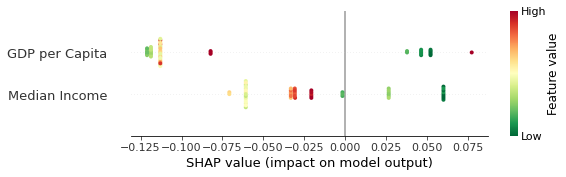

In [120]:
explainer = shap.Explainer(xgbBestE, Xtrain)
shap_values = explainer.shap_values(Xtest)
shap_obj = explainer(Xtest)
# shap.plots.beeswarm(shap_obj)
shap.summary_plot(shap_values, Xtest,cmap=redyellowgreen)

In [119]:
winter = cm.get_cmap('winter')
redyellowgreen = cm.get_cmap('RdYlGn_r')

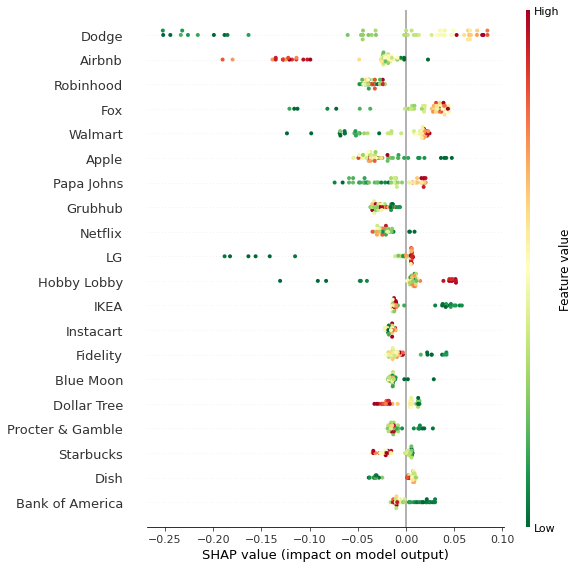

In [117]:
shap.summary_plot(shap_values, XtestB,cmap=winter)

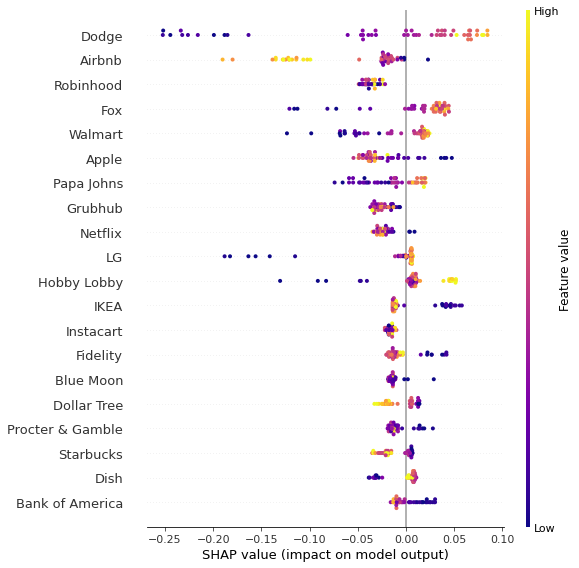

In [108]:
explainer = shap.Explainer(xgbBestB, XtrainB)
shap_values = explainer.shap_values(XtestB)
shap_obj = explainer(XtestB)
# shap.plots.beeswarm(shap_obj)
shap.summary_plot(shap_values, XtestB,cmap=plasma)

## Classification

In [25]:
params = { 'max_depth': [3,5,7,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100,250, 500, 1000],
           'colsample_bytree': [0.3,0.5, 0.7],
          'alpha':[0.0,0.01,0.1,0.5,1.0],
          'lambda':[0.0,0.01,0.1,0.5,1.0],
          'tree_method':['exact'],
#           'eval_metric': ['error','logloss'],
          'objective': ['binary:logistic']
         }
xgbr = xgb.XGBClassifier(seed = 42)

xgbCLF = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_absolute_error', 
                   verbose=2,
                      n_jobs = -1)

In [26]:
xgbCLF.fit(Xtrain,YtrainC)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:16:09] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_est...
                                     seed=42, subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'alpha': [0.0, 0.01, 0.1, 0.5, 1.0],
              

In [28]:
xgbCLF.best_params_

{'alpha': 0.01,
 'colsample_bytree': 0.3,
 'lambda': 1.0,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 1000,
 'objective': 'binary:logistic',
 'tree_method': 'exact'}

In [30]:
preds = xgbCLF.predict(Xtrain)
# traindf = fv[fv['Year'] < 2020]
# trainPred = traindf['predRMask']
print('Accuracy:',accuracy_score(YtrainC, preds))

Accuracy: 0.872


In [31]:
preds = xgbCLF.predict(Xtest)
# traindf = fv[fv['Year'] < 2020]
# trainPred = traindf['predRMask']
print('Accuracy:',accuracy_score(YtestC, preds))

Accuracy: 0.6666666666666666


In [33]:
xgbBest = xgbCLF.best_estimator_

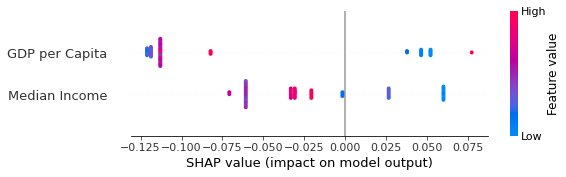

In [123]:
explainer = shap.Explainer(xgbBestE, Xtrain)
shap_values = explainer.shap_values(Xtest)
shap_obj = explainer(Xtest)
# shap.plots.beeswarm(shap_obj)
shap.summary_plot(shap_values, Xtest)

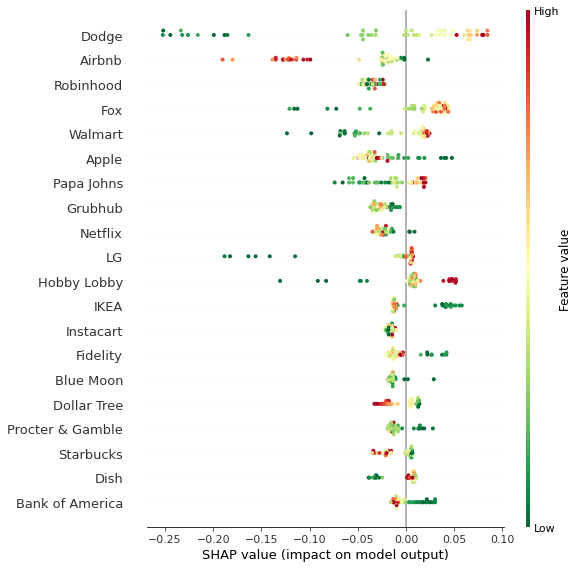

In [125]:
explainer = shap.Explainer(xgbBestB, XtrainB)
shap_values = explainer.shap_values(XtestB)
shap_obj = explainer(XtestB)
# shap.plots.beeswarm(shap_obj)
shap.summary_plot(shap_values, XtestB,cmap=redyellowgreen)

In [126]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, Xtest)

# Combine with Google Trends

In [69]:
df10 = pd.read_csv('drive-download-20220307T231112Z-001/corp_trends2010.csv')
df12 = pd.read_csv('drive-download-20220307T231112Z-001/corp_trends2012.csv')
df14 = pd.read_csv('drive-download-20220307T231112Z-001/corp_trends2014.csv')
df16 = pd.read_csv('drive-download-20220307T231112Z-001/corp_trends2016.csv')
df18 = pd.read_csv('drive-download-20220307T231112Z-001/corp_trends2018.csv')
df20 = pd.read_csv('drive-download-20220307T231112Z-001/corp_trends2020.csv')
trends = [df10,df12,df14,df16,df18,df20]

newTrends = []
years = [2010,2012,2014,2016,2018,2020]
for i in range(len(years)):
    j = trends[i].rename(columns={"Unnamed: 0": "state"})
    y = years[i]
    j['year'] = y
    newTrends.append(j)
    
newTrends
# ndf  = df10.copy()
lTrends = newTrends.pop(0)
for i in newTrends:
    lTrends = lTrends.append(i)
X = lTrends.copy()
X = X.rename(columns={"state": "State",'year':'Year'})
X = pd.merge(X,fv,on=['State','Year'])
X

State  3M Company  AT&T  Absolut  Adidas  Airbnb  Aldi  Allstate  \
0           Alaska           0    70       10      44      56     3        70   
1          Alabama          33    85       53      42      13    39        59   
2         Arkansas          21    77       21      49      17    18        41   
3          Arizona          14    37       45      47      21    11        44   
4       California          10    42       68      98      51    38        25   
..             ...         ...   ...      ...     ...     ...   ...       ...   
296     Washington          32    31       54      53      79     2        48   
297     Washington          32    31       54      53      79     2        48   
298      Wisconsin          37    41       73      63      58    78        29   
299  West Virginia          18    66       44      35      30    53        52   
300        Wyoming           0    28       35      33      50     3        52   

     Amazon  American Airlines  ...  Wish.com  Woodford Reserve  Yum!  Zoom  \
0        91                 45  ...         0                 0     0    77   
1        75                 38  ...         0                 6     0    86   
2        63                 63  ...        83                 3     0    73   
3        80                 63  ...        55                 3     0    81   
4        64                 46  ...         8                 2     0    95   
..      ...                ...  ...       ...               ...   ...   ...   
296      95                 31  ...        52                10     0    82   
297      95                 31  ...        52                10     0    82   
298      86                 44  ...        58                13     0    55   
299      85                 20  ...       100                20     0    36   
300      96                 29  ...        54                 4     0    47   

     eBay  Year  Median Income  GDP per Capita  rep_votes_share  maskActual  
0      76  2010          68825         54134.0         0.693245           1  
1      90  2010          48701        174710.0         0.685798           1  
2      94  2010          45909        102951.0         0.574573           1  
3      68  2010          55795        245668.0         0.556952           1  
4      53  2010          64584       1965886.0         0.447856           0  
..    ...   ...            ...             ...              ...         ...  
296    53  2020          81083         78284.0         0.397715           0  
297    53  2020          81083        209471.0         0.397715           0  
298    64  2020          67094         57314.0         0.513414           1  
299   100  2020          51615         42382.0         0.675627           1  
300    63  2020          65108         62923.0         0.736132           1  

[301 rows x 198 columns]

In [70]:
XtrainB = X[X['Year']<2020]
# Xtrain = Xtrain[['Median Income','GDP per Capita']]
XtrainB = XtrainB.drop(['State', 'Year','rep_votes_share','maskActual'], axis=1)
XtestB = X[X['Year']==2020]
XtestB = XtestB.drop(['State', 'Year','rep_votes_share','maskActual'], axis=1)

YtrainR = X[X['Year']<2020]
YtrainR = YtrainR['rep_votes_share']
YtrainC = X[X['Year']<2020]
YtrainC = YtrainC['maskActual']

YtestR = X[X['Year']==2020]
YtestR = YtestR['rep_votes_share']
YtestC = X[X['Year']==2020]
YtestC = YtestC['maskActual']

In [49]:
params = { 'max_depth': [3,5,7,10],
   'learning_rate': [0.01, 0.05, 0.1],
   'n_estimators': [100,250, 500, 1000],
   'colsample_bytree': [0.3,0.5, 0.7],
  'alpha':[0.0,0.01,0.1,0.5,1.0],
  'lambda':[0.0,0.01,0.1,0.5,1.0],
  'tree_method':['hist'],
#           'eval_metric': ['error','logloss'],
  'objective': ['reg:squarederror','reg:squaredlogerror','reg:logistic']
 }


xgbr = xgb.XGBRegressor(seed=42)

xgbRegressB = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_absolute_error', 
                   verbose=2,
                      n_jobs = -1)
xgbRegressB.fit(Xtrain,YtrainR)
xgbBestBoth = xgbRegressB.best_estimator_

Fitting 5 folds for each of 10800 candidates, totalling 54000 fits


In [52]:
xgbRegressB.best_params_

{'alpha': 0.01,
 'colsample_bytree': 0.3,
 'lambda': 0.01,
 'learning_rate': 0.05,
 'max_depth': 5,
 'n_estimators': 250,
 'objective': 'reg:logistic',
 'tree_method': 'hist'}

In [55]:
# Use the forest's predict method on the test data
XGBpredictions = xgbBestBoth.predict(Xtrain)
# Calculate the absolute errors
errors = abs(XGBpredictions - YtrainR)
# Print out the mean absolute error (mae)
print('Training')
print('Mean Absolute Error:', np.mean(errors), 'degrees.')
# Mean Absolute Error: 3.83 degrees.

Training
Mean Absolute Error: 0.002716645435384765 degrees.


In [57]:
# Use the forest's predict method on the test data
XGBpredictions = xgbBestBoth.predict(Xtest)
# Calculate the absolute errors
errors = abs(XGBpredictions - YtestR)
# Print out the mean absolute error (mae)
print('Testing')
print('Mean Absolute Error:', np.mean(errors), 'degrees.')
# Mean Absolute Error: 3.83 degrees.

Testing
Mean Absolute Error: 0.05390547987470515 degrees.


In [56]:
# Use the forest's predict method on the test data
XGBpredictions = xgbBestBoth.predict(Xtrain)
# Calculate the absolute errors
errors = (XGBpredictions - YtrainR)**2
# Print out the mean absolute error (mae)
print('Training')
print('Mean Squared Error:', np.mean(errors), 'degrees.')
# Mean Absolute Error: 3.83 degrees.

Training
Mean Squared Error: 4.2123955618896836e-05 degrees.


In [58]:
# Use the forest's predict method on the test data
XGBpredictions = xgbBestBoth.predict(Xtest)
# Calculate the absolute errors
errors = (XGBpredictions - YtestR)**2
# Print out the mean absolute error (mae)
print('Testing')
print('Mean Squared Error:', np.mean(errors), 'degrees.')
# Mean Absolute Error: 3.83 degrees.

Testing
Mean Squared Error: 0.006855569967213912 degrees.


In [61]:
X

State  3M Company  AT&T  Absolut  Adidas  Airbnb  Aldi  Allstate  \
0           Alaska           0    70       10      44      56     3        70   
1          Alabama          33    85       53      42      13    39        59   
2         Arkansas          21    77       21      49      17    18        41   
3          Arizona          14    37       45      47      21    11        44   
4       California          10    42       68      98      51    38        25   
..             ...         ...   ...      ...     ...     ...   ...       ...   
296     Washington          32    31       54      53      79     2        48   
297     Washington          32    31       54      53      79     2        48   
298      Wisconsin          37    41       73      63      58    78        29   
299  West Virginia          18    66       44      35      30    53        52   
300        Wyoming           0    28       35      33      50     3        52   

     Amazon  American Airlines  ...  Zoom  eBay  Year  Median Income  \
0        91                 45  ...    77    76  2010          68825   
1        75                 38  ...    86    90  2010          48701   
2        63                 63  ...    73    94  2010          45909   
3        80                 63  ...    81    68  2010          55795   
4        64                 46  ...    95    53  2010          64584   
..      ...                ...  ...   ...   ...   ...            ...   
296      95                 31  ...    82    53  2020          81083   
297      95                 31  ...    82    53  2020          81083   
298      86                 44  ...    55    64  2020          67094   
299      85                 20  ...    36   100  2020          51615   
300      96                 29  ...    47    63  2020          65108   

     GDP per Capita  rep_votes_share  maskActual     predR  predRMask  errors  
0           54134.0         0.693245           1  0.485438          0     0.5  
1          174710.0         0.685798           1  0.647341          1     0.5  
2          102951.0         0.574573           1  0.617917          1     0.5  
3          245668.0         0.556952           1  0.580519          1     0.5  
4         1965886.0         0.447856           0  0.455456          0    -0.5  
..              ...              ...         ...       ...        ...     ...  
296         78284.0         0.397715           0  0.399944          0    -0.5  
297        209471.0         0.397715           0  0.453721          0    -0.5  
298         57314.0         0.513414           1  0.476146          0     0.5  
299         42382.0         0.675627           1  0.604314          1     0.5  
300         62923.0         0.736132           1  0.486471          0     0.5  

[301 rows x 201 columns]

In [68]:
xNew = X.drop(['State', 'Year','rep_votes_share','maskActual','predR','predRMask','errors'], axis=1)
XGBpredictions = xgbBestBoth.predict(xNew)
nfv = fv.copy()
nfv['predR'] = XGBpredictions
nfv['predRMask'] = nfv['predR'].apply(lambda x: round(x))

errors = []
for i, r in nfv.iterrows():
    a = r['maskActual']
    p = r['predRMask']
    if (a==1) and (p==1):
        errors.append(1)
    elif (a==1) and (p!=1):
        errors.append(0.5)
    elif (a==0) and (p==0):
        errors.append(-1)
    else:
        errors.append(-0.5)
nfv['errors'] = errors

In [69]:
nfv

State  Year  Median Income  GDP per Capita  rep_votes_share  \
0          Alabama  2020          54393         45155.0         0.699327   
1           Alaska  2020          74476         68019.0         0.545840   
2          Arizona  2020          66628         52065.0         0.501407   
3         Arkansas  2020          50540         43407.0         0.714792   
4       California  2020          77358         76132.0         0.337262   
..             ...   ...            ...             ...              ...   
296       Virginia  2010          71822        420862.0         0.554455   
297     Washington  2010          66821        359694.0         0.457837   
298  West Virginia  2010          50894         67255.0         0.554045   
299      Wisconsin  2010          59906        252875.0         0.551118   
300        Wyoming  2010          62107         39103.0         0.742049   

     maskActual     predR  predRMask  errors  
0             1  0.695125          1     1.0  
1             1  0.681656          1     1.0  
2             1  0.577798          1     1.0  
3             1  0.557860          1     1.0  
4             0  0.450525          0    -1.0  
..          ...       ...        ...     ...  
296           1  0.412148          0     0.5  
297           0  0.413503          0    -1.0  
298           1  0.494456          0     0.5  
299           1  0.590333          1     1.0  
300           1  0.626405          1     1.0  

[301 rows x 9 columns]

In [73]:
traindfn = nfv[nfv['Year'] < 2020]
# trainPredn = traindfn['predRMask']
print('Accuracy:',accuracy_score(traindfn['predRMask'], traindfn['maskActual']))

Accuracy: 0.696


In [74]:
testDFN = nfv[nfv['Year'] == 2020]
# testPred = testDF['predRMask']
print('Accuracy:',accuracy_score(testDFN['predRMask'], testDFN['maskActual']))

Accuracy: 0.7450980392156863


## Classification

In [39]:
params = { 'max_depth': [3,5,7,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100,250, 500, 1000],
           'colsample_bytree': [0.3,0.5, 0.7],
          'alpha':[0.0,0.01,0.1,0.5,1.0],
          'lambda':[0.0,0.01,0.1,0.5,1.0],
          'tree_method':['exact'],
#           'eval_metric': ['error','logloss'],
          'objective': ['binary:logistic']
         }
xgbr = xgb.XGBClassifier(seed = 42)

xgbCLFB = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_absolute_error', 
                   verbose=2,
                      n_jobs = -1)

In [42]:
xgbCLFB.fit(Xtrain,YtrainC)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits
[17:06:32] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_est...
                                     seed=42, subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'alpha': [0.0, 0.01, 0.1, 0.5, 1.0],
              

In [43]:
preds = xgbCLFB.predict(Xtrain)
# traindf = fv[fv['Year'] < 2020]
# trainPred = traindf['predRMask']
print('Accuracy:',accuracy_score(YtrainC, preds))

Accuracy: 1.0


In [45]:
preds = xgbCLFB.predict(Xtest)
# traindf = fv[fv['Year'] < 2020]
# trainPred = traindf['predRMask']
print('Accuracy:',accuracy_score(YtestC, preds))

Accuracy: 0.9019607843137255


In [51]:
xgbBestC = xgbCLFB.best_estimator_

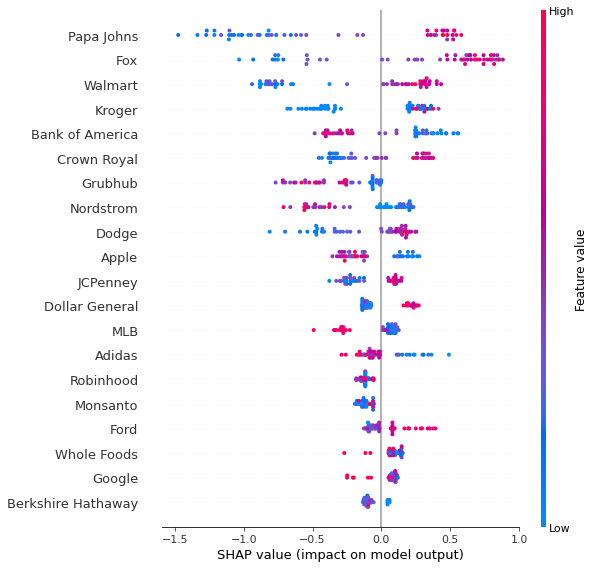

In [52]:
explainer = shap.Explainer(xgbBestC, Xtrain)
shap_values = explainer.shap_values(Xtest)
shap_obj = explainer(Xtest)
# shap.plots.beeswarm(shap_obj)
shap.summary_plot(shap_values, Xtest)

In [53]:
X[['Papa Johns','Apple','Median Income']]

State  3M Company  AT&T  Absolut  Adidas  Airbnb  Aldi  Allstate  \
0           Alaska           0    70       10      44      56     3        70   
1          Alabama          33    85       53      42      13    39        59   
2         Arkansas          21    77       21      49      17    18        41   
3          Arizona          14    37       45      47      21    11        44   
4       California          10    42       68      98      51    38        25   
..             ...         ...   ...      ...     ...     ...   ...       ...   
296     Washington          32    31       54      53      79     2        48   
297     Washington          32    31       54      53      79     2        48   
298      Wisconsin          37    41       73      63      58    78        29   
299  West Virginia          18    66       44      35      30    53        52   
300        Wyoming           0    28       35      33      50     3        52   

     Amazon  American Airlines  ...  Wish.com  Woodford Reserve  Yum!  Zoom  \
0        91                 45  ...         0                 0     0    77   
1        75                 38  ...         0                 6     0    86   
2        63                 63  ...        83                 3     0    73   
3        80                 63  ...        55                 3     0    81   
4        64                 46  ...         8                 2     0    95   
..      ...                ...  ...       ...               ...   ...   ...   
296      95                 31  ...        52                10     0    82   
297      95                 31  ...        52                10     0    82   
298      86                 44  ...        58                13     0    55   
299      85                 20  ...       100                20     0    36   
300      96                 29  ...        54                 4     0    47   

     eBay  Year  Median Income  GDP per Capita  rep_votes_share  maskActual  
0      76  2010          68825         54134.0         0.693245           1  
1      90  2010          48701        174710.0         0.685798           1  
2      94  2010          45909        102951.0         0.574573           1  
3      68  2010          55795        245668.0         0.556952           1  
4      53  2010          64584       1965886.0         0.447856           0  
..    ...   ...            ...             ...              ...         ...  
296    53  2020          81083         78284.0         0.397715           0  
297    53  2020          81083        209471.0         0.397715           0  
298    64  2020          67094         57314.0         0.513414           1  
299   100  2020          51615         42382.0         0.675627           1  
300    63  2020          65108         62923.0         0.736132           1  

[301 rows x 198 columns]

In [56]:
alt.Chart(X).mark_circle(size=60).encode(
    y='GDP per Capita',
    x='Apple',
#     color='Origin',
#     tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
).interactive()

alt.Chart(...)

In [61]:
alt.Chart(X).mark_circle(size=60).encode(
    y='Median Income',
    x='Apple',
    color='GDP per Capita',
#     tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
).interactive()

alt.Chart(...)

In [58]:
alt.Chart(X).mark_circle(size=60).encode(
    y='GDP per Capita',
    x='Papa Johns',
#     color='Origin',
#     tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
).interactive()

alt.Chart(...)

In [60]:
alt.Chart(X).mark_circle(size=60).encode(
    y='Median Income',
    x='Papa Johns',
    color='GDP per Capita',
#     tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
).interactive()

alt.Chart(...)

In [63]:
alt.Chart(X).mark_circle(size=60).encode(
    x='Median Income',
    y='GDP per Capita',
#     color='',
#     tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
).interactive()

alt.Chart(...)

In [64]:
alt.Chart(X).mark_circle(size=60).encode(
    x='rep_votes_share',
    y='Median Income',
#     color='',
#     tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
).interactive()

alt.Chart(...)

In [65]:
alt.Chart(X).mark_circle(size=60).encode(
    x='rep_votes_share',
    y='GDP per Capita',
#     color='',
#     tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
).interactive()

alt.Chart(...)